# Import library 

In [52]:
import pandas as pd
import swifter
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
import sklearn 
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import catboost
import itertools
import numpy as np
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

# Some preprocessing 

## Date Feature

In [3]:
train = pd.read_csv('train_data.csv')
valid = pd.read_csv('valid.csv')
test = pd.read_csv('test.csv')
calendar = pd.read_csv('holidays.csv', sep = ';')

In [4]:
hours_list = pd.DataFrame(data = {'hour':list(range(0,24))})
hours_list['key'] = 0 
calendar['key'] = 0
calendar = calendar.merge(hours_list, on='key', how='outer').drop(['key'], axis= 1)
calendar['datetime'] = pd.to_datetime(calendar.day)+ pd.to_timedelta(calendar.hour, unit='h')
calendar.drop(['day'], axis = 1, inplace = True)

In [5]:
valid['datetime'] = valid.hour.swifter.apply(lambda x: dt.datetime.fromtimestamp(x))
test['datetime'] = test.hour.swifter.apply(lambda x: dt.datetime.fromtimestamp(x))
train['datetime'] = train.timestamp.swifter.apply(lambda x: dt.datetime.fromtimestamp(x))


Pandas Apply:   0%|          | 0/709 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/700 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
def add_date_features(df):
    df['date'] = df['datetime'].dt.date
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['weekofyear'] = df['datetime'].dt.weekofyear
    df['dayofweek'] = df['datetime'].dt.weekday
    df['day'] = df['datetime'].dt.day
    df['year-week'] = df['year'].astype('str') + "-w" + \
                            df['weekofyear'].apply(lambda x: "{:02d}".format(x))
    df['year-month'] = df['year'].astype('str') +"-" +  \
                              df['month'].apply(lambda x: "{:02d}".format(x))
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek-hour'] = df['dayofweek'].astype('str') +"-" +  \
                             df['hour'].apply(lambda x: "{:02d}".format(x))
    
    return df
    

In [7]:

train = add_date_features(train)
test = add_date_features(test)
valid = add_date_features(valid)
calendar = add_date_features(calendar)
calendar = calendar[(calendar['datetime']>=dt.datetime(2019,1,2,0,0,0))&(calendar['datetime']<dt.datetime(2020,2,29,0,0,0))]

## GroupBy

In [8]:

cnt_publication = train.groupby('point').size().to_frame(name='point_size').reset_index()
#Remove points, where total size publications is less than 5 
cnt_publication_size_less_5 = cnt_publication[cnt_publication['point_size']>5]
train = train.merge(cnt_publication_size_less_5, how='inner', on='point')

In [9]:
#Leave only Saint Pi and Len obl 
train = train.query('lat>59.656929822910136 and lat<60.374089897957774 and lon>29.40635082565253 and lon<32.047397760963925').reset_index(drop=True)

In [10]:
# Merge with calendar 
train = train.merge(calendar[['workday', 'date']].drop_duplicates().reset_index(drop = True), how='inner', on= 'date')

In [11]:
gr_hour = train.groupby(['point', 'point_size', 'lon', 'lat','datetime','date','year','month', 
                'weekofyear','year-month','year-week','dayofweek','hour','dayofweek-hour','workday']
              ).agg(
    {'datetime':['count'], 
     'likescount':['mean', 'sum'],
     'commentscount':['mean', 'sum'], 
     'symbols_cnt':'sum', 
     'words_cnt':'sum', 
     'hashtags_cnt':'sum',
     'mentions_cnt':'sum',
     'links_cnt':'sum',
     'emoji_cnt':'sum'}
    )
gr_hour.columns = ["_".join(x) for x in gr_hour.columns.ravel()]
gr_hour.rename(columns = {"datetime_count":"cnt_publications"}, inplace = True)
gr_hour.reset_index(inplace = True)


In [11]:
gr_date = train.groupby(['point', 'point_size', 'lon', 'lat','date','year','month', 
                'weekofyear','year-month','year-week','dayofweek','workday']
              ).agg(
    {'datetime':['count'], 
     'likescount':'sum',
     'commentscount':'sum', 
     'symbols_cnt':'sum', 
     'words_cnt':'sum', 
     'hashtags_cnt':'sum',
     'mentions_cnt':'sum',
     'links_cnt':'sum',
     'emoji_cnt':'sum'}
    )
gr_date.columns = ["_".join(x) for x in gr_date.columns.ravel()]
gr_date.rename(columns = {"datetime_count":"cnt_publications"}, inplace = True)
gr_date.reset_index(inplace = True)

In [12]:
gr_month =  gr_hour.groupby(['point', 'point_size', 'year-month'],as_index=False)['cnt_publications'].sum()


# Analysis

## Distribution of points by the size of publications

In [13]:
rang = [0,10,30,50,100,200,300,500,2000,5000,10000,50000,200000] 
distr_points = pd.DataFrame(columns=['points size','points']) 
for n in list(range(len(rang)-1)): 
    i=rang[n] 
    j = rang[n+1] 
    s = cnt_publication[(cnt_publication['point_size'] >= i)&(cnt_publication['point_size'] < j)]['point_size'].count()
    distr_points = distr_points.append({'points size': f'{i}-{j-1}','points':s},ignore_index=True) 



In [14]:
gr_hour.point_size.max()

196054

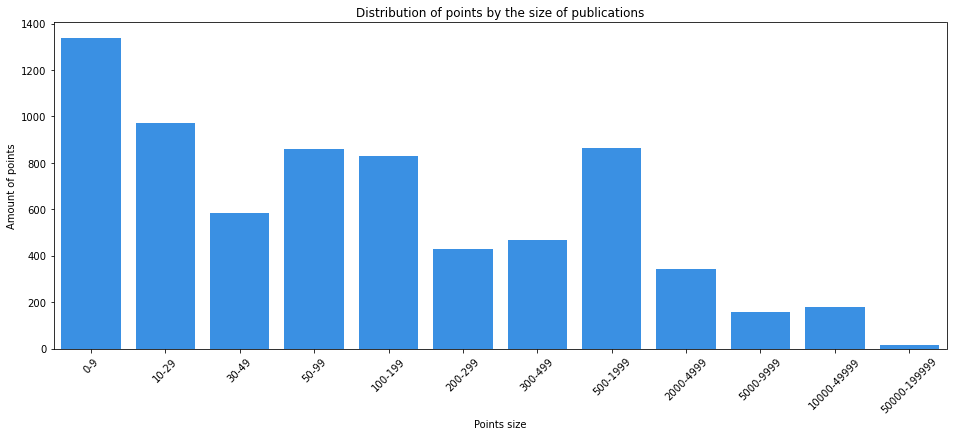

In [15]:
plt.figure(figsize=(16,6))
sns.barplot(x ='points size',y ='points',data = distr_points , color = 'dodgerblue')
plt.xlabel("Points size")
plt.ylabel("Amount of points")
plt.title("Distribution of points by the size of publications") 
plt.xticks(rotation=45)
plt.show()

In [16]:
rang = [0,200,1000,5000,10000,200000] 
distr_points2 = pd.DataFrame(columns=['points size','points']) 
for n in list(range(len(rang)-1)): 
    i=rang[n] 
    j = rang[n+1] 
    s = cnt_publication[(cnt_publication['point_size'] >= i)&(cnt_publication['point_size'] < j)]['point_size'].count()
    mean_hour = gr_hour[(gr_hour['point_size'] >= i)&(gr_hour['point_size'] < j)]['cnt_publications'].mean()
    mean_day = gr_date[(gr_date['point_size'] >= i)&(gr_date['point_size'] < j)]['cnt_publications'].mean()
    mean_month = gr_month[(gr_month['point_size'] >= i)&(gr_month['point_size'] < j)]['cnt_publications'].mean()
    sum_posts = gr_hour[(gr_hour['point_size'] >= i)&(gr_hour['point_size'] < j)]['cnt_publications'].sum()
    distr_points2 = distr_points2.append(
        {'points size': f'{i}-{j-1}',
         'points':s, 
         'sum_posts' : sum_posts,
         'mean_posts_day' : mean_day ,
         'mean_posts_hour':mean_hour,
         'mean_posts_month' : mean_month
         },ignore_index=True) 

Text(0, 0.5, 'Posts')

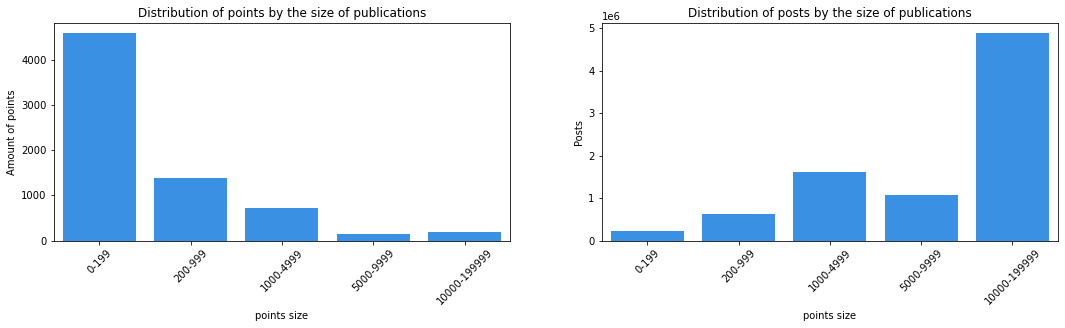

In [17]:

fig, axs = plt.subplots(ncols=2,figsize=(18, 4))
sns.barplot(x ='points size',y ='points',data = distr_points2 , color = 'dodgerblue',ax=axs[0])
axs[0].set(title = 'Distribution of points by the size of publications')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_ylabel('Amount of points')

sns.barplot(x ='points size',y ='sum_posts',data = distr_points2 , color = 'dodgerblue',ax=axs[1])
axs[1].set(title = 'Distribution of posts by the size of publications')
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_ylabel('Posts')

Text(0, 0.5, 'Avg publications')

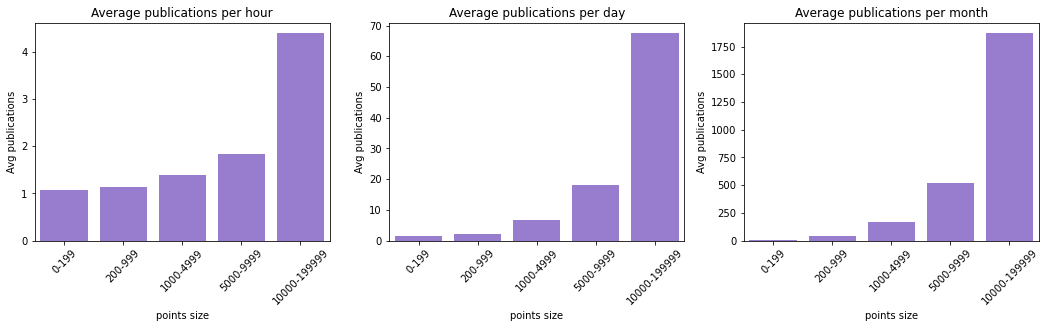

In [18]:

fig, axs = plt.subplots(ncols=3,figsize=(18, 4))
sns.barplot(x ='points size', y ='mean_posts_hour',data = distr_points2 , color = 'mediumpurple',ax=axs[0])
axs[0].set(title = 'Average publications per hour')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_ylabel('Avg publications')

sns.barplot(x ='points size', y ='mean_posts_day',data = distr_points2 , color = 'mediumpurple',ax=axs[1])
axs[1].set(title = 'Average publications per day')
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_ylabel('Avg publications')

sns.barplot(x ='points size', y ='mean_posts_month',data = distr_points2 , color = 'mediumpurple',ax=axs[2])
axs[2].set(title = 'Average publications per month')
axs[2].tick_params(axis='x', rotation=45)
axs[2].set_ylabel('Avg publications')

In [19]:
distr_points2['perc_points'] = distr_points2.points/distr_points2.points.sum()
distr_points2['perc_sum_posts'] = distr_points2.sum_posts/distr_points2.sum_posts.sum()

In [20]:
distr_points2[:4].points.sum()

6846

* We see that most locations have a small number of publications and intermittent time series.
* The number of locations in which the total number of publications does not exceed 199 is 65 percent of the total number of locations. The total number of posts in locations where the number of posts is more than 10,000 is 58 percent of all posts, and the number of such locations is 2.7 percent of all locations. 
* 6846 locations have an average of almost 2 new posts per hour and 195 locations have an average 4,5 new posts per hour 
* If we look at the daily average, we see a more noticeable difference in the groups. In the most popular locations, the average value reaches 67 publications per day. In the most unpopular locations, the average value fluctuates from 1 to 2 posts per day

## Distribution of points by time of publications

### Hour

In [21]:
total_hour = gr_hour.groupby(['hour'],as_index=False).agg({'cnt_publications':['sum', 'mean']})
total_hour.columns = ["_".join(x) for x in total_hour.columns.ravel()]
total_hour.rename(columns = {"hour_":"hour"}, inplace = True)

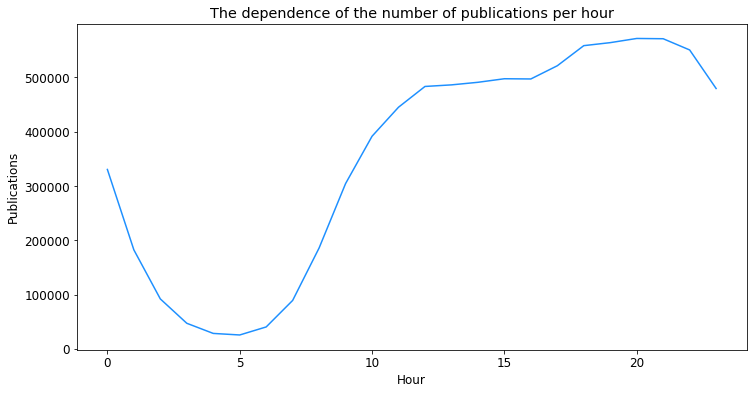

In [28]:
plt.figure(figsize =(12,6))
plt.rcParams['font.size'] = '12'
sns.lineplot(x ='hour',y ='cnt_publications_sum',
data = total_hour , color = 'dodgerblue')
plt.xlabel("Hour")
plt.ylabel("Publications")
plt.title("The dependence of the number of publications per hour") 
plt.show()

We see that the smallest number of publications is at night from 1 a.m. to 9 a.m.. Most activity from 5pm to 11pm

In [24]:
total_dayofweek_hour= gr_hour.groupby(['dayofweek-hour'],as_index=False)['cnt_publications'].sum()

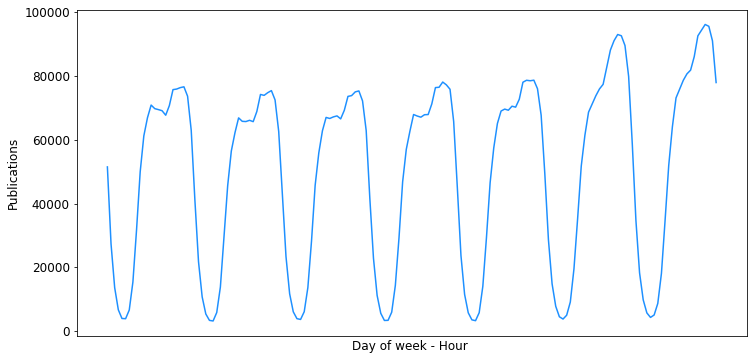

In [29]:
plt.figure(figsize =(12,6))
sns.lineplot(x='dayofweek-hour',y='cnt_publications',
data=total_dayofweek_hour , color = 'dodgerblue')
plt.xlabel("Day of week - Hour ")
plt.ylabel("Publications")

plt.xticks([])
plt.show()


### Day of week 

In [26]:
total_dayofweek = gr_hour[gr_hour['workday']!='Holiday'].groupby(['dayofweek'],as_index=False)['cnt_publications'].sum()

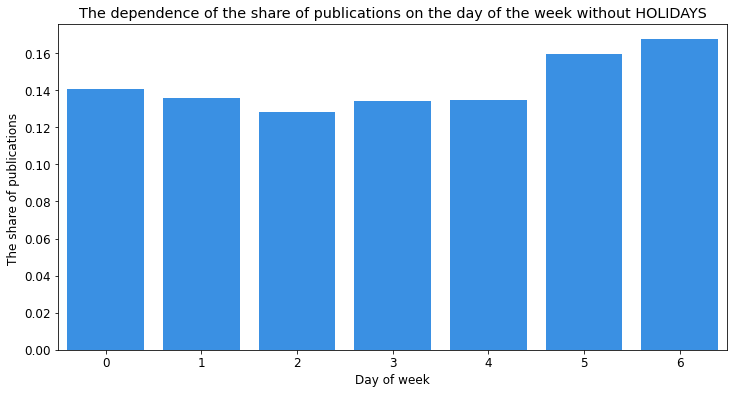

In [31]:
s = total_dayofweek.cnt_publications.sum()
total_dayofweek['perc_publ'] = total_dayofweek['cnt_publications']/s
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '12'
sns.barplot(x ='dayofweek',y ='perc_publ',data = total_dayofweek , color = 'dodgerblue')

plt.xlabel("Day of week")
plt.ylabel("The share of publications ")
plt.title("The dependence of the share of publications on the day of the week without HOLIDAYS") 
plt.show()

In [32]:
total_dayofweek_date = gr_date[gr_date['workday']!='Holiday'].groupby(['dayofweek'],as_index=False)['cnt_publications'].mean()

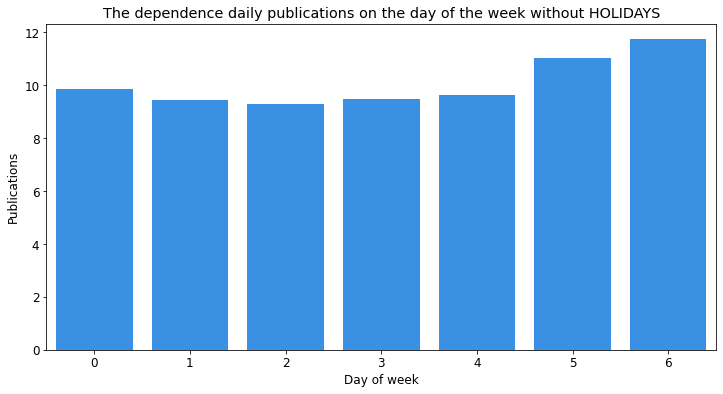

In [33]:
plt.figure(figsize=(12,6))
sns.barplot(x ='dayofweek',y ='cnt_publications',data = total_dayofweek_date , color = 'dodgerblue')
plt.xlabel("Day of week")
plt.ylabel("Publications")
plt.title("The dependence daily publications on the day of the week without HOLIDAYS") 
plt.show()

### Weekend, Holiday, Workday


Most posts on weekends

In [34]:
#Кол-во постов в праздиники/выходные дни/ будни
wk = gr_hour.groupby(['date', 'workday'])['cnt_publications'].sum().reset_index()
wk.groupby(['workday'])['cnt_publications'].mean()

workday
Holiday    23619.105263
Weekend    23122.150442
Workday    20358.655303
Name: cnt_publications, dtype: float64

### Month

In [35]:
total_month =  gr_hour.groupby(['year-month'],as_index=False).agg({'cnt_publications':['sum', 'mean']})
total_month.columns = ["_".join(x) for x in total_month.columns.ravel()]
total_month.rename(columns = {"year-month_":"year-month"}, inplace = True)

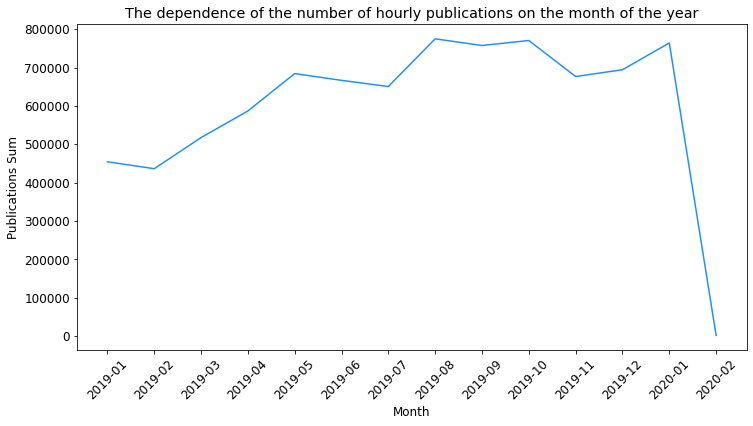

In [36]:
plt.figure(figsize=(12,6))
sns.lineplot(x='year-month',y='cnt_publications_sum',
data=total_month , color = 'dodgerblue')
plt.xlabel("Month")
plt.ylabel("Publications Sum")
plt.title("The dependence of the number of hourly publications on the month of the year") 
plt.xticks(rotation=45)
plt.show()

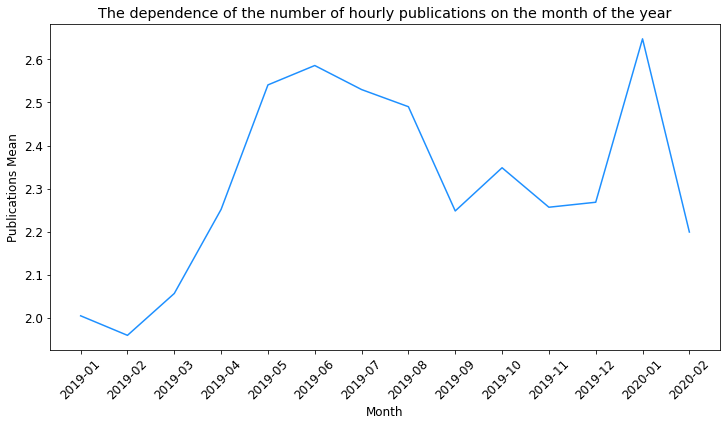

In [37]:
plt.figure(figsize=(12,6))
sns.lineplot(x='year-month',y='cnt_publications_mean',
data=total_month , color = 'dodgerblue')
plt.xlabel("Month")
plt.ylabel("Publications Mean")
plt.title("The dependence of the number of hourly publications on the month of the year") 
plt.xticks(rotation=45)
plt.show()

We see a growth trend in publications. On average, there are more publications in the summer and on New Year's holidays

### Date

In [38]:
total_date =  gr_date.groupby(['date'],as_index=False).agg({'cnt_publications':['sum', 'mean']})
total_date.columns = ["_".join(x) for x in total_date.columns.ravel()]
total_date.rename(columns = {"date_":"date"}, inplace = True)

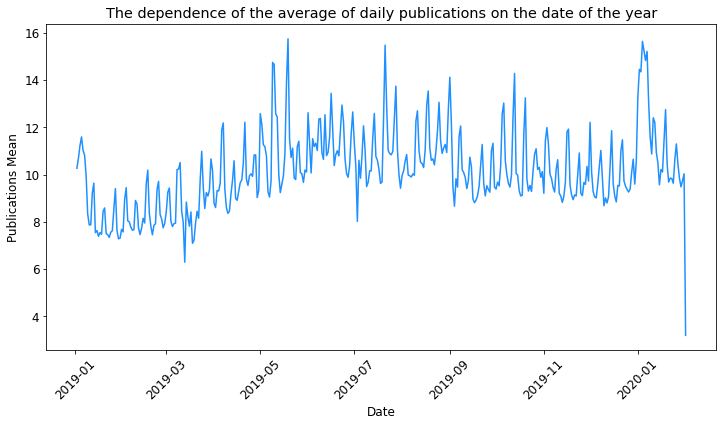

In [39]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='cnt_publications_mean', data=total_date , color = 'dodgerblue')
plt.xlabel("Date")
plt.ylabel("Publications Mean")
plt.title("The dependence of the average of daily publications on the date of the year") 
plt.xticks(rotation=45)
plt.show()

## Plot time series location

In [41]:
p = gr_hour[['point', 'lat','lon','point_size']].drop_duplicates().reset_index(drop = True)
pd.set_option('display.max_colwidth', None)
p =p.sort_values(by = 'point_size')
top_1000 = p[-100:]


In [48]:
#крейсер Аврора
gr_one_point1 = gr_hour.query('point =="0101000020E6100000D86C3D4C9E563E40236E4BFC40FA4D40"') 
gr_one_point_date1 = gr_one_point1.groupby(['date', 'lat', 'lon'])['cnt_publications'].sum().reset_index()

#Дворцовая площадь 
gr_one_point2 = gr_hour.query('point =="0101000020E61000006141807FDE503E40A554BF083DF84D40"') 
gr_one_point_date2 = gr_one_point2.groupby(['date', 'lat', 'lon'])['cnt_publications'].sum().reset_index()

<AxesSubplot:xlabel='date', ylabel='cnt_publications'>

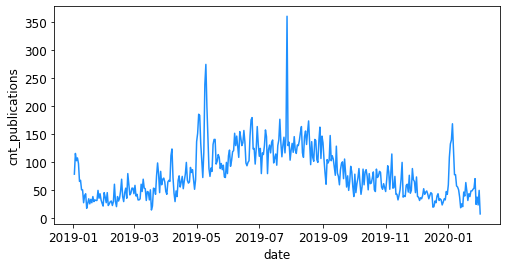

In [49]:
plt.figure(figsize=(8,4))
sns.lineplot(x='date',y='cnt_publications', data = gr_one_point_date1  , color = 'dodgerblue')

<AxesSubplot:xlabel='date', ylabel='cnt_publications'>

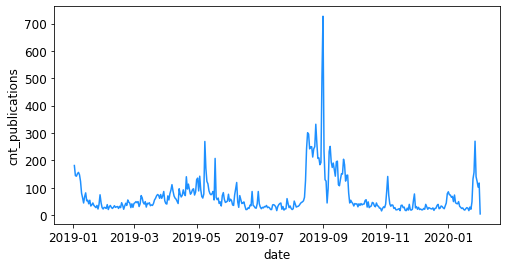

In [50]:
plt.figure(figsize=(8,4))
sns.lineplot(x='date',y='cnt_publications', data = gr_one_point_date2  , color = 'dodgerblue')

In [52]:
latmean = top_1000['lat'][-10:].mean()
lonmean = top_1000['lon'][-10:].mean()
m1 = folium.Map(location= [latmean,lonmean],
                tiles='openstreetmap', 
                zoom_start=13)


     

for lat,lan, size in zip(top_1000[-10:]['lat'],top_1000[-10:]['lon'], top_1000[-10:]['point_size']):
    folium.Marker(location=[lat,lan],
                  tooltip=' {}'.format(size)).add_to(m1)

m1

Top 10 locations: 

* Исаакиевский собор - 196054
* Проспект Добролюбова - 188468 
* Севкабель порт -145191
* Дворцовая площадь - 120424
* Петропавловская крепость - 115011
* Парк 300-летия - 104442
* Новая Голландия - 94352 
* Ледовый дворец - 70902
* Газпром Арена - 70037
* Лофт проект Этажи - 69015


# Outliers

This part is not used in the final preparation of data for models

In [48]:
def replace_outliers(df): 
    
    df['cnt_publications_mask'] = df['cnt_publications'].mask((df['workday'] == "Holiday"))
    
    q1=df.cnt_publications_mask.quantile(0.1)
    q3=df.cnt_publications_mask.quantile(0.9)
    
    outliers_index=df[(df.cnt_publications_mask<q1)|(df.cnt_publications_mask>q3)]['cnt_publications_mask'].index.values
    
    df['outliers']= df['cnt_publications_mask'].apply(lambda x: 1 if x<q1 or x>q3 else 0)
    
    series=df['cnt_publications']
  #  alpha= 0.01
    alpha= 0.01
    result=[series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        fcast=alpha * series[n] + (1 - alpha) * result[n]
    result=pd.DataFrame(result,columns=['exp']) 
    
    df['cnt_public_with_outliers'] =  df['cnt_publications']
    df.cnt_publications.loc[outliers_index] = result.exp.loc[outliers_index]
    
    return df
    

In [ ]:
rmv_h_1 =  h_1[h_1['year-month']!= '2020-02'].reset_index( drop = True)
points_list =  rmv_h_1['point'].unique()
#points_list = ['0101000020E61000006141807FDE503E402B348A98ADF94D40']
gr_hour_without_otliers = []
for i, point in enumerate(points_list): 
    if i == 0:
        point_data = rmv_h_1[rmv_h_1['point']==point].reset_index(drop = True)
        gr_hour_without_otliers = replace_outliers(point_data)
    else:
        point_data = rmv_h_1[rmv_h_1['point']==point].reset_index(drop = True)
        point_data = replace_outliers(point_data)
        gr_hour_without_otliers = gr_hour_without_otliers.append(point_data, ignore_index = True)

In [ ]:

k = gr_hour_without_otliers[gr_hour_without_otliers['point'] == '0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB4D40']
n = gr_hour[gr_hour['point'] == '0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB4D40']
a = k.loc[k['outliers'] == 1, ['datetime','cnt_publications']] #anomaly
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(n.datetime, n['cnt_publications'], color='blue',label = 'Normal')
#ax.scatter(a.datetime, a['cnt_publications'], color='red', label = 'Anomaly')
ax.plot(k.datetime, k['cnt_publications'], color='black', label = 'Publications without outliers')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Publications',fontsize=14)
plt.legend()

# Forecast

In [12]:

def dc (df):
    mas = []
    for i in itertools.product(calendar.datetime, df['point'].unique()):
         mas.append(list(i))
    dec=pd.DataFrame(mas,columns=['datetime','point'])
    return dec

In [13]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

## High-level forecast for points with point_size>=1500

In [14]:
data_1500=gr_hour.query('point_size>=1500').groupby(['datetime','date','year','month', 
                'weekofyear','year-month','year-week','dayofweek','hour','dayofweek-hour','workday'])['cnt_publications'].sum().reset_index()
data_1500.drop([ 'date','year','month', 
                'weekofyear','year-month','year-week','dayofweek','hour','dayofweek-hour','workday'
                ], axis = 1, inplace = True)
data_1500 = calendar.merge(data_1500, on = 'datetime', how = 'left')
data_1500 = data_1500.fillna(0)
data_1500 = data_1500.sort_values(by = ['datetime']).reset_index(drop=True)

In [15]:
data_1500['workday'] = data_1500.workday.astype('category')
data_1500 = encode_and_bind(data_1500, 'workday').drop(['workday'], axis = 1)

In [16]:
data_1500['lag_posts_30days_rolling'] = data_1500['cnt_publications'].shift(24*30).rolling(window=24*7, min_periods=24, win_type="triang").std()
data_1500['lag_posts_60days_rolling'] = data_1500['cnt_publications'].shift(24*60).rolling(window=24*7, min_periods=24, win_type="triang").mean()
data_1500['lag_posts_90days_rolling'] = data_1500['cnt_publications'].shift(24*90).rolling(window=24*7, min_periods=24, win_type="triang").mean()
data_1500['lag_posts_180days_rolling'] = data_1500['cnt_publications'].shift(24*180).rolling(window=24*7, min_periods=24, win_type="triang").mean()
data_1500['lag_posts_360days_rolling'] = data_1500['cnt_publications'].shift(24*360).rolling(window=24*7, min_periods=24, win_type="triang").mean()
data_1500 = data_1500.set_index('datetime')

In [17]:
test_1500 = data_1500[data_1500['date']>=dt.date(2020,2,1)]
train_1500 = data_1500[data_1500['date']<dt.date(2020,2,1)]
test_1500  = test_1500.drop([  'date','year-week','year-month','dayofweek-hour'], axis = 1)
train_1500 = train_1500.drop([ 'date','year-week', 'dayofweek-hour'], axis = 1)
y_train_1500= train_1500[(train_1500['year-month'] != '2020-01')].drop(['year-month'], axis =1 )['cnt_publications']
x_train_1500= train_1500[(train_1500['year-month'] != '2020-01')].drop(['cnt_publications','year-month'], axis =1 )
x_valid_1500= train_1500[(train_1500['year-month'] =='2020-01')].drop(['cnt_publications','year-month'], axis =1 )
y_valid_1500= train_1500[(train_1500['year-month'] =='2020-01')].drop(['year-month'], axis =1 )['cnt_publications']
x_test_1500 = test_1500.drop(['cnt_publications'], axis =1 )

In [18]:

model_catb_1500=CatBoostRegressor( max_depth=6,
    iterations = 300,
    learning_rate=0.2,   
    l2_leaf_reg = 3,
    eval_metric = 'RMSE',
    min_data_in_leaf= 10,
    #cat_features =  x_train.columns, 
    random_state=52)
model_catb_1500.fit(
    x_train_1500, 
    y_train_1500, 
    eval_set=[(x_train_1500, y_train_1500), (x_valid_1500, y_valid_1500)], 

    )

CB_test= model_catb_1500.predict(x_test_1500)
#catboost.plot_importance(model_catb)

0:	learn: 398.8972744	test: 398.8972744	test1: 497.3632540	best: 497.3632540 (0)	total: 140ms	remaining: 41.9s
1:	learn: 340.3227078	test: 340.3227078	test1: 437.2275496	best: 437.2275496 (1)	total: 142ms	remaining: 21.1s
2:	learn: 290.4645809	test: 290.4645809	test1: 409.1803782	best: 409.1803782 (2)	total: 144ms	remaining: 14.2s
3:	learn: 250.5979513	test: 250.5979513	test1: 391.0223649	best: 391.0223649 (3)	total: 145ms	remaining: 10.8s
4:	learn: 221.7557744	test: 221.7557744	test1: 381.7575271	best: 381.7575271 (4)	total: 147ms	remaining: 8.68s
5:	learn: 197.3793921	test: 197.3793921	test1: 373.9939403	best: 373.9939403 (5)	total: 149ms	remaining: 7.3s
6:	learn: 178.4052535	test: 178.4052535	test1: 365.9387899	best: 365.9387899 (6)	total: 151ms	remaining: 6.31s
7:	learn: 165.1378507	test: 165.1378507	test1: 361.8550920	best: 361.8550920 (7)	total: 153ms	remaining: 5.57s
8:	learn: 154.1444593	test: 154.1444593	test1: 362.8337173	best: 361.8550920 (7)	total: 154ms	remaining: 4.99s
9:

99:	learn: 68.4095274	test: 68.4095274	test1: 283.3990980	best: 283.2008716 (55)	total: 313ms	remaining: 626ms
100:	learn: 68.1068851	test: 68.1068851	test1: 283.3074524	best: 283.2008716 (55)	total: 315ms	remaining: 620ms
101:	learn: 67.8608991	test: 67.8608991	test1: 283.2603368	best: 283.2008716 (55)	total: 317ms	remaining: 614ms
102:	learn: 67.6405684	test: 67.6405684	test1: 283.0488034	best: 283.0488034 (102)	total: 318ms	remaining: 609ms
103:	learn: 67.2615306	test: 67.2615306	test1: 281.3266916	best: 281.3266916 (103)	total: 320ms	remaining: 603ms
104:	learn: 67.0931511	test: 67.0931511	test1: 281.5207437	best: 281.3266916 (103)	total: 322ms	remaining: 598ms
105:	learn: 66.7987390	test: 66.7987390	test1: 281.7614243	best: 281.3266916 (103)	total: 324ms	remaining: 593ms
106:	learn: 66.5900049	test: 66.5900049	test1: 281.1012209	best: 281.1012209 (106)	total: 325ms	remaining: 587ms
107:	learn: 66.3624936	test: 66.3624936	test1: 281.2202696	best: 281.1012209 (106)	total: 327ms	rema

202:	learn: 53.2853693	test: 53.2853693	test1: 284.5649920	best: 281.0757902 (115)	total: 488ms	remaining: 233ms
203:	learn: 53.1934105	test: 53.1934105	test1: 284.5812018	best: 281.0757902 (115)	total: 490ms	remaining: 230ms
204:	learn: 53.1136857	test: 53.1136857	test1: 284.9142377	best: 281.0757902 (115)	total: 491ms	remaining: 228ms
205:	learn: 52.9856585	test: 52.9856585	test1: 284.9458769	best: 281.0757902 (115)	total: 493ms	remaining: 225ms
206:	learn: 52.8751241	test: 52.8751241	test1: 284.9376583	best: 281.0757902 (115)	total: 495ms	remaining: 222ms
207:	learn: 52.7977221	test: 52.7977221	test1: 284.7623357	best: 281.0757902 (115)	total: 504ms	remaining: 223ms
208:	learn: 52.7506974	test: 52.7506974	test1: 284.7414045	best: 281.0757902 (115)	total: 507ms	remaining: 221ms
209:	learn: 52.6752554	test: 52.6752554	test1: 284.3052589	best: 281.0757902 (115)	total: 509ms	remaining: 218ms
210:	learn: 52.6531826	test: 52.6531826	test1: 283.9296220	best: 281.0757902 (115)	total: 511ms	

In [19]:
model_xgb_1500=XGBRegressor( max_depth=8,
    n_estimators=100,
   min_child_weight= 3, 
    colsample_bytree=1, 
    subsample=0.8, 
    learning_rate=0.1,   
    reg_lambda=0.15,
    seed=52)
model_xgb_1500.fit(
    x_train_1500, 
    y_train_1500, 
    eval_metric="rmse", 
    eval_set=[(x_train_1500, y_train_1500), (x_valid_1500, y_valid_1500)], 
    verbose=True, 
    early_stopping_rounds = 50)

#XB_test= model.predict(x_test)
xgb.plot_importance(model_xgb_1500)

[0]	validation_0-rmse:805.99161	validation_1-rmse:981.49629
[1]	validation_0-rmse:726.87698	validation_1-rmse:913.56392
[2]	validation_0-rmse:655.93597	validation_1-rmse:851.86272
[3]	validation_0-rmse:592.08727	validation_1-rmse:792.69445
[4]	validation_0-rmse:534.56740	validation_1-rmse:743.26984
[5]	validation_0-rmse:482.88969	validation_1-rmse:698.58244
[6]	validation_0-rmse:436.61364	validation_1-rmse:659.89866
[7]	validation_0-rmse:395.00347	validation_1-rmse:621.33869
[8]	validation_0-rmse:357.69296	validation_1-rmse:586.38111
[9]	validation_0-rmse:324.28387	validation_1-rmse:552.31176
[10]	validation_0-rmse:294.29362	validation_1-rmse:525.73532
[11]	validation_0-rmse:267.29637	validation_1-rmse:499.26836
[12]	validation_0-rmse:242.86715	validation_1-rmse:481.70089
[13]	validation_0-rmse:221.01689	validation_1-rmse:465.52987
[14]	validation_0-rmse:201.41387	validation_1-rmse:448.79696
[15]	validation_0-rmse:184.12969	validation_1-rmse:431.66422
[16]	validation_0-rmse:168.65106	v

NameError: name 'xgb' is not defined

In [21]:
x_test_1500['yhat_ctb'] = model_catb_1500.predict(x_test_1500)

In [22]:
x_test_1500['yhat_xgb'] = model_xgb_1500.predict(x_test_1500.drop(['yhat_ctb'], axis  = 1))

Text(0.5, 0, 'Date')

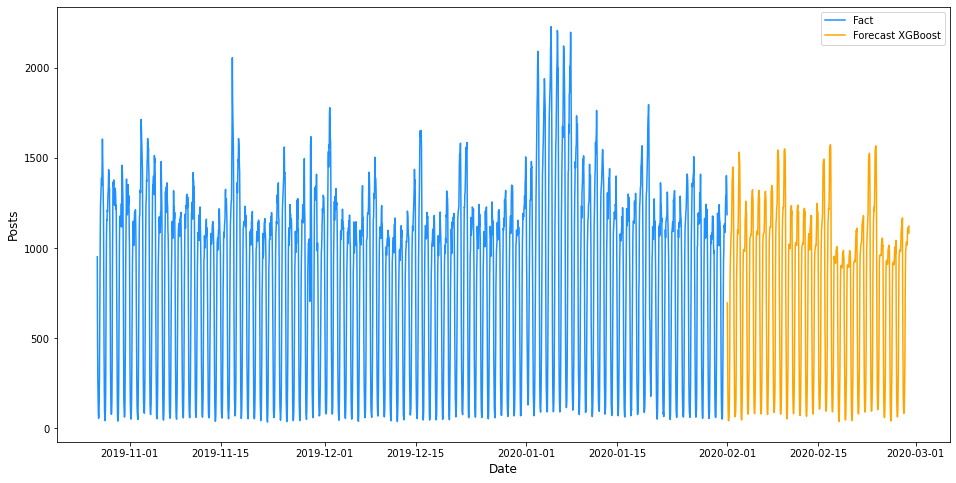

In [23]:

plt.figure(figsize=(16,8))
plt.plot(data_1500.reset_index()['datetime'][-3000:-672],data_1500['cnt_publications'][-3000:-672], label='Fact',color = 'dodgerblue')
plt.plot(x_test_1500.reset_index()['datetime'],x_test_1500['yhat_xgb'], label='Forecast XGBoost',color = 'orange')
plt.legend()
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)

## Forecat each point with point_size >=1500 

In [24]:
def split_train_test (df, valid, test) :
    test_data = df[df['date']>=dt.date(2020,2,1)]
    train = df[df['date']<dt.date(2020,2,1)]

    v= test_data.merge(valid[['point', 'datetime', 'sum']], on = ['point', 'datetime'], how = 'inner')
    v = v.drop(['cnt_publications'], axis = 1).rename(columns = {'sum':'cnt_publications'})
    v = v.drop([ 'datetime', 'date','year-week','dayofweek-hour'], axis = 1)

    train = train.drop(['datetime', 'date','year-week', 'dayofweek-hour'], axis = 1)
    #train = train.query('cnt_publications != 0').reset_index( drop = True)
    y_train= train['cnt_publications']
    x_train= train.drop(['cnt_publications','year-month'], axis = 1 )

    x_valid= v.drop(['cnt_publications','year-month'], axis = 1 )
    y_valid= v['cnt_publications']

    
    x_test = test_data.drop(['cnt_publications'], axis =1 ).merge(test[['point']].drop_duplicates(), on =['point'], how = 'inner' )
    x_test = x_test.drop(['datetime', 'date','year-week', 'dayofweek-hour','year-month' ],axis =1)

    x_train.set_index('point', inplace = True)
    x_valid.set_index('point', inplace = True)
    x_test.set_index('point', inplace = True)
    return y_train, x_train, x_valid, y_valid, x_test

In [25]:
h_1 = gr_hour[(gr_hour['point_size'] >= 1500)]
h_1 = h_1[h_1['date']<dt.date(2020,2,1)]
h_1.reset_index(inplace = True, drop=True)

In [26]:
dec = dc(h_1)
h_1.drop([ 'lon', 'lat',  'date', 'year',
       'month', 'weekofyear', 'year-month', 'year-week', 'dayofweek', 'hour',
       'dayofweek-hour', 'workday'], axis = 1, inplace = True)
h_1 = dec.merge(h_1, on = ['point', 'datetime'], how = 'left')
h_1= calendar.merge(h_1, on = 'datetime', how = 'left')
h_1 = h_1.fillna(0)
h_1= h_1.sort_values(by = ['point','datetime']).reset_index(drop=True)

In [ ]:
month_day_of_week_hour = h_1.groupby(['point', 'month','dayofweek', 'hour']
              ).agg(
    {'cnt_publications':['mean', 'median', 'max', 'min'],
     'commentscount_sum':'mean', 
     'symbols_cnt_sum':'mean', 
     'words_cnt_sum':'mean', 
     'hashtags_cnt_sum':'mean',
     'mentions_cnt_sum':'mean',
     'links_cnt_sum':'mean',
     'emoji_cnt_sum':'mean'}
    )   
month_day_of_week_hour.columns = ["_".join(x) for x in month_day_of_week_hour.columns.ravel()]
month_day_of_week_hour.reset_index(inplace = True)
month_day_of_week_hourb['month'] = month_day_of_week_hour.month.apply(lambda x: 1 if x ==12 else x+1)
month_day_of_week_hour.columns = ['point', 'month','dayofweek', 'hour', 'cnt_publications_prev_monthdayhour_mean','cnt_publications_prev_monthdayhour_median',
       'cnt_publications_prev_monthdayhour_max', 'cnt_publications_prev_monthdayhour_min',
       'commentscount_prev_monthdayhour_mean', 'symbols_cnt_prev_monthdayhour_mean', 'words_cnt_prev_monthdayhour_mean',
       'hashtags_cnt_prev_monthdayhour_mean', 'mentions_cnt_prev_monthdayhour_mean', 'links_cnt_prev_monthdayhour_mean',
       'emoji_cnt_prev_monthdayhour_mean']



year_month = h_1.groupby(['point','year', 'month', 'hour']
              ).agg(
    {'cnt_publications':'mean', 
     'commentscount_sum':'mean', 
     'symbols_cnt_sum':'mean', 
     'words_cnt_sum':'mean', 
     'hashtags_cnt_sum':'mean',
     'mentions_cnt_sum':'mean',
     'links_cnt_sum':'mean',
     'emoji_cnt_sum':'mean'}
    )
year_month.reset_index(inplace = True)
year_month['year'] = year_month.year.apply(lambda x:  x+1)
year_month.columns = ['point','year', 'month', 'hour', 'cnt_publications_monthhour_mean',
       'commentscount_monthhour_mean', 'symbols_cnt_monthhour_mean', 'words_cnt_monthhour_mean',
       'hashtags_cnt_monthhour_mean', 'mentions_cnt_monthhour_mean', 'links_cnt_monthhour_mean',
       'emoji_cnt_sum_monthhour_mean']



weekofyear_mean =  h_1.groupby(['point', 'weekofyear', 'hour']
              ).agg(
    {'cnt_publications':['mean', 'median', 'max', 'min'], 
     'commentscount_sum':'mean', 
     'symbols_cnt_sum':'mean', 
     'words_cnt_sum':'mean', 
     'hashtags_cnt_sum':'mean',
     'mentions_cnt_sum':'mean',
     'links_cnt_sum':'mean',
     'emoji_cnt_sum':'mean'}
    )
#weekofyear_mean.columns = ["_weekofyear_mean".join(x) for x in weekofyear_mean.columns.values]
weekofyear_mean.columns = ["_".join(x) for x in weekofyear_mean.columns.ravel()]
weekofyear_mean.reset_index(inplace = True)
weekofyear_mean.columns = ['point', 'weekofyear', 'hour', 'cnt_publications_weekofyear_mean',
       'cnt_publications_weekofyear_median','cnt_publications_weekofyear_max','cnt_publications_weekofyear_min',
       'commentscount_weekofyear_mean', 'symbols_cnt_weekofyear_mean', 'words_cnt_weekofyear_mean',
       'hashtags_cnt_weekofyear_mean', 'mentions_cnt_weekofyear_mean', 'links_cnt_weekofyear_mean',
       'emoji_cnt_weekofyear_mean']



dayofweek_mean =  h_1.groupby(['point', 'dayofweek', 'hour']
              ).agg(
    {'cnt_publications':['mean', 'median', 'max', 'min'],}
    )
dayofweek_mean.columns = ["_".join(x) for x in dayofweek_mean.columns.ravel()]
dayofweek_mean.reset_index(inplace = True)
dayofweek_mean.columns = ['point', 'dayofweek', 'hour', 'cnt_publications_dayofweekhour_mean',
'cnt_publications_dayofweekhour_median','cnt_publications_dayofweekhour_max','cnt_publications_dayofweekhour_min'
    ]

In [27]:
def add_features(h):
    h['lag_posts_30days'] = h['cnt_publications'].shift(24*30).where(h.point.eq(h.point.shift(24*30)))
    h['trend_lag_posts_30days'] = h['cnt_publications'] -  h['cnt_publications'].shift(24).where(h.point.eq(h.point.shift(24)))
    h['trend_lag_posts_30days'] = h['trend_lag_posts_30days'].shift(24*30).where(h.point.eq(h.point.shift(24*30)))
    h['lag_posts_60days'] = h['cnt_publications'].shift(24*60).where(h.point.eq(h.point.shift(24*60)))
    h['lag_posts_90days'] = h['cnt_publications'].shift(24*90).where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_180days'] = h['cnt_publications'].shift(24*180).where(h.point.eq(h.point.shift(24*180)))
    h['lag_likes_30days'] = h['likescount_sum'].shift(24*30)
    h['lag_posts_180days_ewm95']  = h['cnt_publications'].shift(24*180).ewm(alpha=0.95).mean().where(h.point.eq(h.point.shift(24*30)))
    h['workday'] = h.workday.astype('category')
    h = encode_and_bind(h, 'workday').drop(['workday'], axis = 1)
    #h['lag_posts_with_outl_90days_rolling'] = h['cnt_public_with_outliers'].shift(24*90).rolling(window=24*7, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_90_30days_rolling'] = h['cnt_publications'].shift(24*30).rolling(window=24*90, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*30)))
    h['lag_posts_90_60days_rolling'] = h['cnt_publications'].shift(24*60).rolling(window=24*90, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*60)))
    h['lag_posts_90_90days_rolling'] = h['cnt_publications'].shift(24*90).rolling(window=24*90, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_90_180days_rolling'] = h['cnt_publications'].shift(24*180).rolling(window=24*90, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*180)))

    h['lag_posts_30_30days_rolling'] = h['cnt_publications'].shift(24*30).rolling(window=24*30, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*30)))
    h['lag_posts_30_60days_rolling'] = h['cnt_publications'].shift(24*60).rolling(window=24*30, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*60)))
    h['lag_posts_30_90days_rolling'] = h['cnt_publications'].shift(24*90).rolling(window=24*30, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_30_180days_rolling'] = h['cnt_publications'].shift(24*180).rolling(window=24*30, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*180)))

    h['lag_posts_30_30days_std_rolling'] = h['cnt_publications'].shift(24*30).rolling(window=24*30, min_periods=24, win_type="triang").std().where(h.point.eq(h.point.shift(24*30)))
    h['lag_posts_30_60days_std_rolling'] = h['cnt_publications'].shift(24*60).rolling(window=24*30, min_periods=24, win_type="triang").std().where(h.point.eq(h.point.shift(24*60)))
    h['lag_posts_30_90days_std_rolling'] = h['cnt_publications'].shift(24*90).rolling(window=24*30, min_periods=24, win_type="triang").std().where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_30_180days_std_rolling'] = h['cnt_publications'].shift(24*180).rolling(window=24*30, min_periods=24, win_type="triang").std().where(h.point.eq(h.point.shift(24*180)))


    h['lag_posts_60_30days_rolling'] = h['cnt_publications'].shift(24*30).rolling(window=24*60, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*30)))
    h['lag_posts_60_60days_rolling'] = h['cnt_publications'].shift(24*60).rolling(window=24*60, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*60)))
    h['lag_posts_60_90days_rolling'] = h['cnt_publications'].shift(24*90).rolling(window=24*60, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_60_180days_rolling'] = h['cnt_publications'].shift(24*180).rolling(window=24*60, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*180)))

    h['lag_posts_7_30days_rolling'] = h['cnt_publications'].shift(24*30).rolling(window=24*7, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*30)))
    h['lag_posts_7_60days_rolling'] = h['cnt_publications'].shift(24*60).rolling(window=24*7, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*60)))
    h['lag_posts_7_90days_rolling'] = h['cnt_publications'].shift(24*90).rolling(window=24*7, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*90)))
    h['lag_posts_7_180days_rolling'] = h['cnt_publications'].shift(24*180).rolling(window=24*7, min_periods=24, win_type="triang").mean().where(h.point.eq(h.point.shift(24*180)))
    return h 

In [28]:
h_1 = add_features(h_1)

In [29]:
h_1.shape


(8314488, 54)

In [ ]:
#h_1 = h_1.merge(month_day_of_week_hour, how = 'left', on = ['point', 'month', 'dayofweek', 'hour'])
#h_1 = h_1.merge(weekofyear_mean[['point','weekofyear',  'hour','cnt_publications_weekofyear_mean','cnt_publications_weekofyear_median','cnt_publications_weekofyear_max','cnt_publications_weekofyear_min']],
#        how = 'left', on = ['point', 'weekofyear',  'hour'])
#h_1 = h_1.merge(year_month[['point','year', 'month',  'hour','cnt_publications_monthhour_mean']],
#        how = 'left', on = ['point','year', 'month',  'hour'])
#h_1 = h_1.merge(dayofweek_mean[['point','dayofweek',  'hour','cnt_publications_dayofweekhour_mean',
#'cnt_publications_dayofweekhour_median','cnt_publications_dayofweekhour_max','cnt_publications_dayofweekhour_min']],
#        how = 'left', on = ['point','dayofweek',  'hour'])
#h_1 = h_1.fillna(0)

In [30]:
print(h_1.point.nunique())
#h_1 = h_1.set_index('point')

819


In [31]:
train_features = h_1[[
    'hour', 
    'datetime', 
    'date', 
    'year', 
    'month', 
    'weekofyear', 
    'dayofweek',
    'year-week', 
    'year-month', 
    'dayofweek-hour', 
    'day', 
    'point',
    #'point_size',
    #'label_point',
    'cnt_publications', 
    #'likescount_mean', 
    #'likescount_sum',
    #'commentscount_mean', 
    #'commentscount_sum', 
    #'symbols_cnt_sum',
    #'words_cnt_sum', 
    #'hashtags_cnt_sum', 
    #'mentions_cnt_sum',
    #'links_cnt_sum', 
    #'emoji_cnt_sum', 
    'lag_posts_30days',
    #'trend_lag_posts_30days', 
    'lag_posts_60days', 
    'lag_posts_90days',
    # 'lag_posts_with_outl_90days_rolling',
    'lag_posts_180days', 
    #'lag_posts_90_30days_rolling',
    #'lag_posts_90_60days_rolling',
    #'lag_posts_90_90days_rolling',
    #'lag_posts_90_180days_rolling',
    #'lag_posts_60_30days_rolling',
    #'lag_posts_60_60days_rolling',
    #'lag_posts_60_90days_rolling',
    #'lag_posts_60_180days_rolling',
    #'lag_posts_30_30days_rolling',
    #'lag_posts_30_60days_rolling',
    #'lag_posts_30_90days_rolling',
    #'lag_posts_30_180days_rolling',
    'lag_posts_30_30days_std_rolling',
    'lag_posts_30_60days_std_rolling',
    'lag_posts_30_90days_std_rolling',
    'lag_posts_30_180days_std_rolling',
    'lag_posts_7_30days_rolling',
    'lag_posts_7_60days_rolling',
    'lag_posts_7_90days_rolling',
    'lag_posts_7_180days_rolling',
    #'lag_posts_180days_random',
    #'lag_posts_180days_ewm95',
    #'lag_likes_30days', 
    #'lag_posts_30days_ewm95',
    'workday_Holiday', 
    'workday_Weekend', 
    #'workday_Workday',
    #'cnt_publications_prev_monthdayhour_mean', 
    #'cnt_publications_prev_monthdayhour_median',
    #'cnt_publications_dayofweekhour_mean',
    #'cnt_publications_monthhour_mean',
    #'commentscount_monthdayhour_mean',
    #'symbols_cnt_monthdayhour_mean', 
    #'words_cnt_monthdayhour_mean',
    #'hashtags_cnt_monthdayhour_mean', 
    #'mentions_cnt_monthdayhour_mean',
    #'links_cnt_monthdayhour_mean', 
    #'emoji_cnt_sum_monthdayhour_mean',
    #'cnt_publications_weekofyear_mean',
    #'cnt_publications_weekofyear_max',
    #'cnt_publications_weekofyear_min',
    #'cnt_publications_weekofyear_median'
]]

In [32]:
y_train_point_1500, x_train_point_1500, x_valid_point_1500, y_valid_point_1500, x_test_point_1500 = split_train_test( train_features, valid, test)


In [33]:
def metric(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', np.mean(np.abs((labels- preds) / labels)) 


In [34]:
def metric_base(y, yhat):
    return 'error', np.mean(np.abs((yhat- y) / yhat)) 

### Linear Regression

In [81]:
model_linear = LinearRegression()
model_linear.fit(x_train_point_1500.drop([ 'lag_posts_30days','lag_posts_60days', 'lag_posts_90days','lag_posts_180days', 
    'lag_posts_30_30days_std_rolling',
   'lag_posts_30_60days_std_rolling',
    'lag_posts_30_90days_std_rolling',
    'lag_posts_30_180days_std_rolling',
    'lag_posts_7_30days_rolling',
    'lag_posts_7_60days_rolling',
    'lag_posts_7_90days_rolling',
    'lag_posts_7_180days_rolling'], axis = 1)
, y_train_point_1500)

LinearRegression()

In [82]:
 metric_base( y_valid_point_1500 , model_linear.predict(x_valid_point_1500.drop([ 'lag_posts_30days','lag_posts_60days', 'lag_posts_90days','lag_posts_180days', 
    'lag_posts_30_30days_std_rolling',
   'lag_posts_30_60days_std_rolling',
    'lag_posts_30_90days_std_rolling',
    'lag_posts_30_180days_std_rolling',
    'lag_posts_7_30days_rolling',
    'lag_posts_7_60days_rolling',
    'lag_posts_7_90days_rolling',
    'lag_posts_7_180days_rolling'], axis = 1)))

('error', 7.287365279107177)

### LightGBM

In [85]:
lgb_train = lgb.Dataset(x_train_point_1500, y_train_point_1500)
lgb_eval = lgb.Dataset(x_valid_point_1500, y_valid_point_1500, reference=lgb_train)

In [89]:
params = {
    'boosting': 'gbdt',
     'max_depth':6,
    'colsample_bytree': 0.8,
    'subsample':0.7,
    'objective': 'regression',
  #  'num_leaves': 10,
    'learnnig_rage': 0.1,
    'reg_alpha' : 0.01, 
    'reg_lambda' : 0.01,
    'metric': {'l2','l1'},
    'verbose': -1,
    'random_state': 52
}
model_lgb = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=False,
                 early_stopping_rounds=30)

In [37]:
LGB_test= model_lgb.predict(x_valid_point_1500)

Text(0, 0.5, 'features')

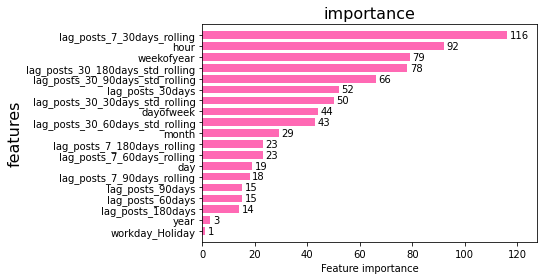

In [38]:
lgb.plot_importance(model_lgb, color='hotpink',height = 0.7, grid = False )
plt.title('importance', fontsize = 16)
plt.yticks(fontsize = 10)
plt.ylabel('features', fontsize = 16)

In [39]:
metric_base(LGB_test, y_valid_point_1500 )

('error', 0.46073033921709466)

### XGBoost

In [90]:
model=XGBRegressor ( max_depth =8,
    n_estimators=50,
    min_child_weight=30, 
    colsample_bytree=0.8, 
    subsample=0.6, 
    learning_rate=0.1,   
    reg_lambda=0.1,
    alpha = 0.1,
    seed=52)

model.fit(
    x_train_point_1500, 
    y_train_point_1500, 
    eval_metric= metric, 
    eval_set=[(x_train_point_1500, y_train_point_1500), (x_valid_point_1500, y_valid_point_1500)], 
    verbose=False, 
    early_stopping_rounds = 10
    )

XB_test= model.predict(x_valid_point_1500)

In [41]:
metric_base(XB_test, y_valid_point_1500 )

('error', 0.4459656214601565)

Text(0, 0.5, 'features')

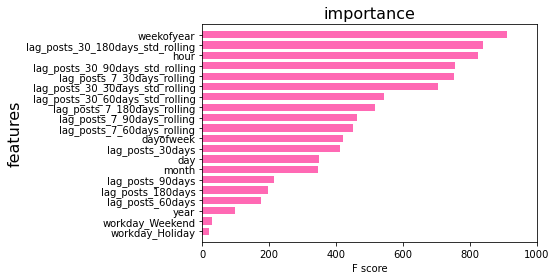

In [53]:
xgb.plot_importance(model, color='hotpink',height = 0.7, grid = False , show_values = False)
plt.title('importance', fontsize = 16)
plt.yticks(fontsize = 10)
plt.ylabel('features', fontsize = 16)

### CatBoost

In [91]:
model_catb=CatBoostRegressor(  max_depth=8,
    iterations = 170,
    learning_rate=0.05,   
    l2_leaf_reg = 7,
    eval_metric = 'MAE',
    min_data_in_leaf= 50,
    subsample = 0.8,
    random_state=52)

model_catb.fit(
    x_train_point_1500, 
    y_train_point_1500, 
    eval_set=[(x_train_point_1500, y_train_point_1500), (x_valid_point_1500, y_valid_point_1500)], 
    verbose=False, 
    )

CB_test= model_catb.predict(x_valid_point_1500)

In [92]:
metric_base(CB_test, y_valid_point_1500 )

('error', 0.4545145549518974)

Text(0, 0.5, 'features')

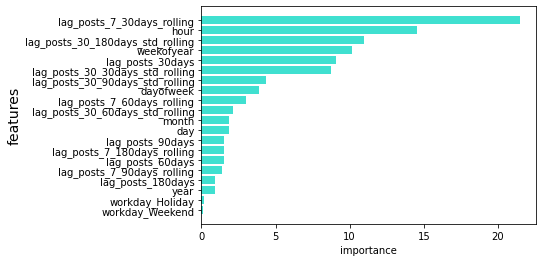

In [56]:
sorted_feature_importance = model_catb.feature_importances_.argsort()
plt.barh(x_train_point_1500.columns[sorted_feature_importance], 
        model_catb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel('importance',fontsize=10)
plt.ylabel('features',fontsize=14)

### Results

In [74]:
y_train_point_1500, x_train_point_1500, x_valid_point_1500, y_valid_point_1500, x_test_point_1500 = split_train_test( train_features, valid, test)

In [75]:
x_test_point_1500['yhat_xgb'] = model.predict(x_test_point_1500)
x_test_point_1500['yhat_ctb'] = model_catb.predict(x_test_point_1500.drop(['yhat_xgb'], axis = 1))
x_test_point_1500['yhat_lgbm'] = model_lgb.predict(x_test_point_1500.drop(['yhat_xgb', 'yhat_ctb'], axis = 1))
t = x_test_point_1500.reset_index()
v = test[['point','year', 'month', 'day', 'hour', 'sum', 'error']]
to_check = t.merge(v,
        on =['point','year', 'month', 'day', 'hour'], how = 'inner')

to_check['error_xgb_with_ceil'] = to_check.apply(lambda x: np.abs(np.ceil(x['yhat_xgb']) - x['sum'])/ np.ceil(x['yhat_xgb']) , axis = 1)
to_check['error_ctb_with_ceil'] = to_check.apply(lambda x: np.abs(np.ceil(x['yhat_ctb']) - x['sum'])/ np.ceil( x['yhat_ctb']) , axis = 1)
to_check['error_lgbm_with_ceil'] = to_check.apply(lambda x: np.abs(np.ceil(x['yhat_lgbm']) - x['sum'])/ np.ceil( x['yhat_lgbm']) , axis = 1)

to_check['error_ctb'] = to_check.apply(lambda x: metric_base(x['sum'], x['yhat_ctb'])[1] , axis = 1)
to_check['error_xgb'] = to_check.apply(lambda x: metric_base(x['sum'], x['yhat_xgb'])[1] , axis = 1)
to_check['error_lgbm'] = to_check.apply(lambda x:metric_base(x['sum'], x['yhat_lgbm'])[1] , axis = 1)

to_check['delta_xgb'] = to_check['error'] - to_check['error_xgb']
to_check['delta_ctb'] = to_check['error'] - to_check['error_ctb']
to_check['delta_lgbm'] = to_check['error'] - to_check['error_lgbm']

print("Baseline error = {}\nXGBoost error with \
      ceil predictions = {}\nCatBoost error with ceil predictions = {}\nLightGBM error with ceil predictions = {}\n\
XGBoost error  = {}\nCatBoost error = {}\nLightGBM error = {} "
       .format (to_check['error'].mean(), 
        to_check['error_xgb_with_ceil'].mean(),
        to_check['error_ctb_with_ceil'].mean(),
        to_check['error_lgbm_with_ceil'].mean(),
        to_check['error_xgb'].mean(), 
        to_check['error_ctb'].mean(), 
        to_check['error_lgbm'].mean()         
               ))

Baseline error = 2.641502260992367
XGBoost error with       ceil predictions = 0.7501012462499006
CatBoost error with ceil predictions = 0.7043456039526247
LightGBM error with ceil predictions = 0.8278019446704821
XGBoost error  = 1.00334154515119
CatBoost error = 0.977254539421221
LightGBM error = 1.1472881685703578 


In [81]:
to_check[['point', 'sum', 'error', 'yhat_xgb', 'error_xgb', 'yhat_ctb','error_ctb', 'yhat_lgbm', 'error_lgbm'  ]].sort_values(by = 'error_ctb') [120:140]

,point,sum,error,yhat_xgb,error_xgb,yhat_ctb,error_ctb,yhat_lgbm,error_lgbm
198,0101000020E61000005428070AD9353E40582A871690FD4D40,6,0.254735,4.769934,0.257879,5.224217,0.148497,4.291498,0.398113
580,0101000020E6100000D86C3D4C9E563E40BE7BD74EA5F54D40,6,0.254735,5.755425,0.042495,5.224136,0.148515,5.551218,0.080844
400,0101000020E61000009E01B90998523E407AB3D8B484F74D40,5,1.254735,4.530015,0.103749,5.874370,0.148845,4.218656,0.185212
494,0101000020E6100000BE6E039E6A643E403DF3BDF394004E40,6,0.754735,5.717934,0.049330,5.217631,0.149947,4.836733,0.240507
509,0101000020E6100000C1A95B4732403E40494A4ED65FF74D40,15,3.302796,12.739315,0.177457,13.040718,0.150243,13.316778,0.126399
660,0101000020E6100000EC2F1F510A6D3E4058AA511532F34D40,11,1.504735,7.880144,0.395914,9.553127,0.151455,7.959823,0.381940
49,0101000020E61000001CD7DE65BE533E40E4A1F770CEF74D40,5,0.421402,4.316727,0.158285,4.333445,0.153816,3.235111,0.545542
357,0101000020E61000009A92A823F9323E40DDC94EE7B4FD4D40,13,1.283581,11.629992,0.117800,11.257871,0.154748,10.810761,0.202506
562,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF54D40,8,0.354735,5.995773,0.334273,6.927862,0.154757,5.266793,0.518951
168,0101000020E61000004D98FA185E5C3E40CAE971F73AF74D40,8,1.421402,10.049469,0.203938,6.924567,0.155307,7.682880,0.041276


### Reconciliation-adjusted predictions

In [99]:
t = x_test_point_1500.reset_index()
t['yhat_ctb'] = t.yhat_ctb.apply(lambda x: 0 if  x <0 else x)
fcst_point_hour = t.groupby([ 'hour','point'])['yhat_ctb'].sum().reset_index()
fcst_hour = t.groupby(['hour'])['yhat_ctb'].sum().reset_index()
fcst_hour =fcst_hour.rename( columns = {'yhat_ctb':'yhat_ctb_total'})
fcst_point_hour = fcst_point_hour.merge( fcst_hour ,on = 'hour', how = 'left')
fcst_point_hour['part'] = fcst_point_hour['yhat_ctb']/fcst_point_hour['yhat_ctb_total']
t3 = to_check.merge(fcst_point_hour[[  'hour', 'point', 'part']], on = ['hour','point'], how = 'left').drop(['yhat_ctb'], axis = 1)
t3 = t3.merge(x_test_1500[['year', 'month', 'day', 'hour', 'yhat_ctb']], on = ['year', 'month', 'day', 'hour'], how = 'left')
t3['new'] = t3['part']*	t3['yhat_ctb']
t3['our_error_new'] = t3.apply(lambda x: np.abs(np.ceil(x['new']) - x['sum'])/ np.ceil(x['new']) , axis = 1)
t = t.merge(fcst_point_hour[[ 'hour', 'point', 'part']], on = [ 'hour','point'], how = 'left')
t= t.merge(x_test_1500[['year', 'month', 'day', 'hour', 'yhat_ctb']], on = ['year', 'month', 'day', 'hour'], how = 'left')
t['new'] = t['part']*t['yhat_ctb_y']

In [100]:
t3['our_error_new'].mean()


0.4544790612160727

In [101]:
t3[['new', 'yhat_xgb', 'sum']].sum()

new         7124.564113
yhat_xgb    4665.086914
sum         6509.000000
dtype: float64

There are disadvantages here because it imposes general patterns on points where local models work better. But on average it improves the quality of the model

### Plot forecast

POINT == "0101000020E6100000AB00D6E0B14B3E406379569882F64D40"

Text(0.5, 0, 'Date')

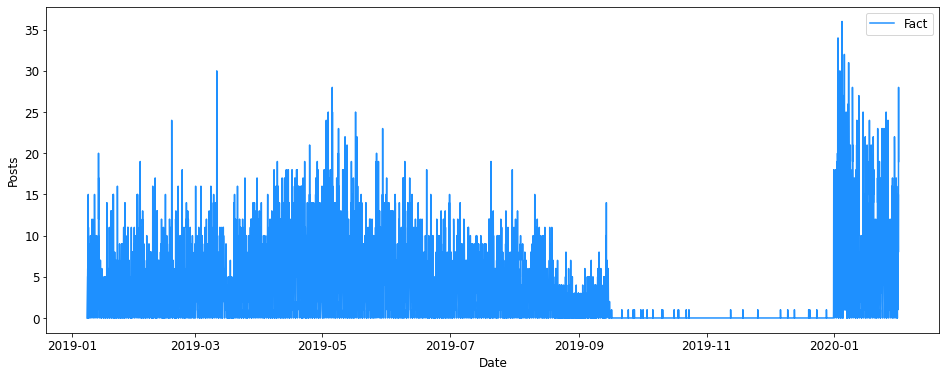

In [149]:
p = h_1.reset_index().query('point == "0101000020E6100000AB00D6E0B14B3E406379569882F64D40" and year-month!="2020-02"').reset_index(drop=True)
f = t.reset_index().merge(calendar[['datetime','year', 'month', 'day', 'hour']], on = ['year', 'month', 'day', 'hour'], how = 'inner')\
.query('point == "0101000020E6100000AB00D6E0B14B3E406379569882F64D40"').reset_index(drop=True).sort_values(by = 'datetime')
plt.rcParams['font.size'] = '12'
plt.figure(figsize=(16,6))
plt.plot(p['datetime'][-10000:-672],p['cnt_publications'][-10000:-672], label='Fact',color = 'dodgerblue')
plt.legend()
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)

Text(0.5, 0, 'Date')

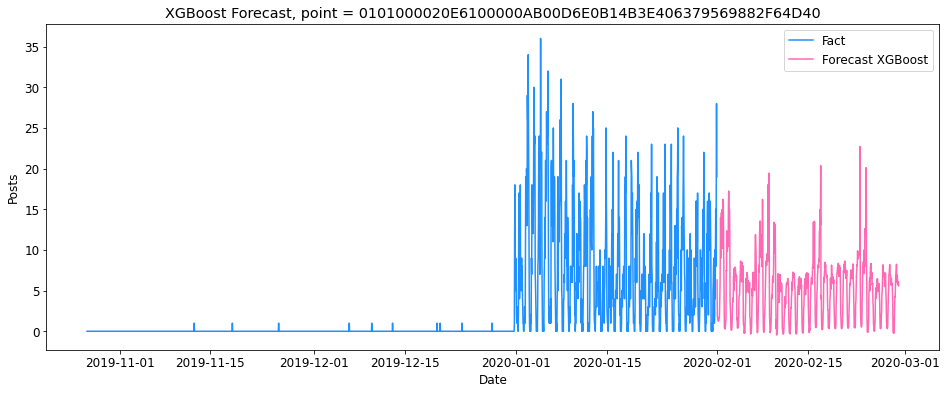

In [151]:

plt.figure(figsize=(16,6))
plt.plot(p['datetime'][-3000:-672],p['cnt_publications'][-3000:-672], label='Fact',color = 'dodgerblue')
plt.plot(f['datetime'],f['yhat_xgb'], label='Forecast XGBoost',color = 'hotpink')
plt.title("XGBoost Forecast, point = 0101000020E6100000AB00D6E0B14B3E406379569882F64D40") 
plt.legend()
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)

Text(0.5, 0, 'Date')

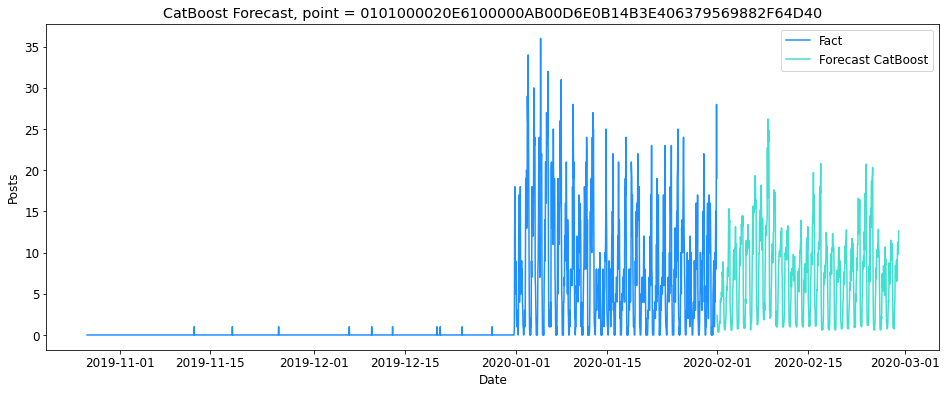

In [152]:

plt.figure(figsize=(16,6))
plt.plot(p['datetime'][-3000:-672],p['cnt_publications'][-3000:-672], label='Fact',color = 'dodgerblue')
plt.plot(f['datetime'],f['yhat_ctb'], label='Forecast CatBoost',color = 'turquoise')
plt.legend()
plt.title("CatBoost Forecast, point = 0101000020E6100000AB00D6E0B14B3E406379569882F64D40") 
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)

#### POINT == "0101000020E6100000C2DD138409843E4009249E9F54F24D40" 

Text(0.5, 0, 'Date')

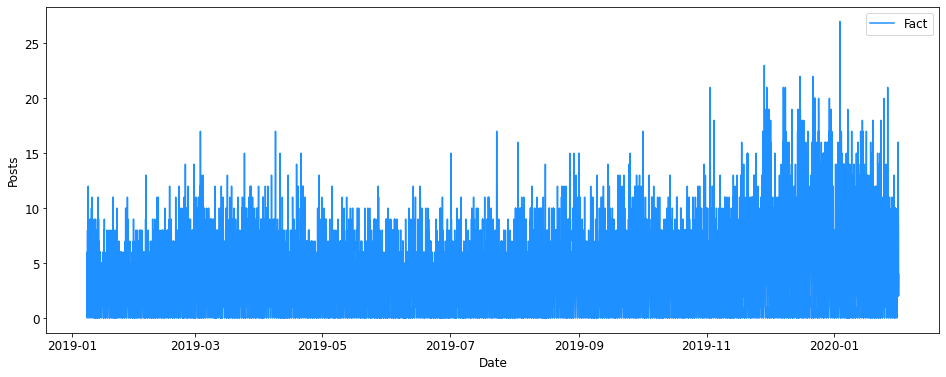

In [142]:
p = h_1.reset_index().query('point == "0101000020E6100000C2DD138409843E4009249E9F54F24D40" and year-month!="2020-02"').reset_index(drop=True)
f = t.reset_index().merge(calendar[['datetime','year', 'month', 'day', 'hour']], on = ['year', 'month', 'day', 'hour'], how = 'inner')\
.query('point == "0101000020E6100000C2DD138409843E4009249E9F54F24D40"').reset_index(drop=True).sort_values(by = 'datetime')
plt.rcParams['font.size'] = '12'
plt.figure(figsize=(16,6))
plt.plot(p['datetime'][-10000:-672],p['cnt_publications'][-10000:-672], label='Fact',color = 'dodgerblue')
plt.legend()
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)

Text(0.5, 0, 'Date')

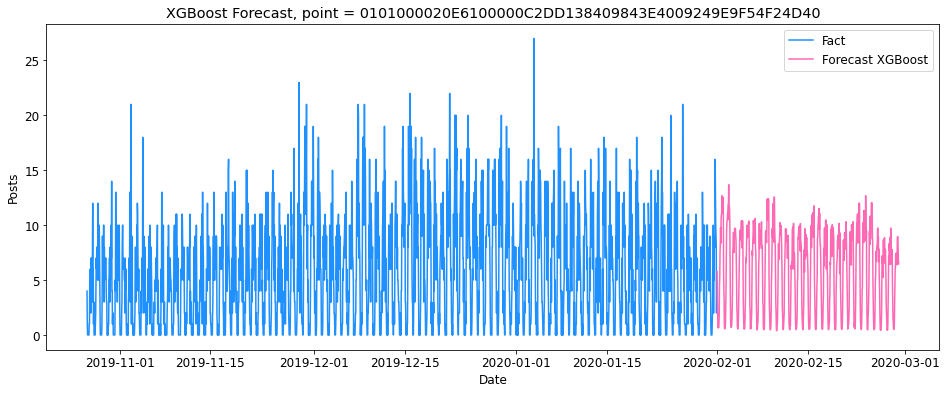

In [146]:

plt.figure(figsize=(16,6))
plt.plot(p['datetime'][-3000:-672],p['cnt_publications'][-3000:-672], label='Fact',color = 'dodgerblue')
plt.plot(f['datetime'],f['yhat_xgb'], label='Forecast XGBoost',color = 'hotpink')
plt.title("XGBoost Forecast, point = 0101000020E6100000C2DD138409843E4009249E9F54F24D40") 
plt.legend()
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)

Text(0.5, 0, 'Date')

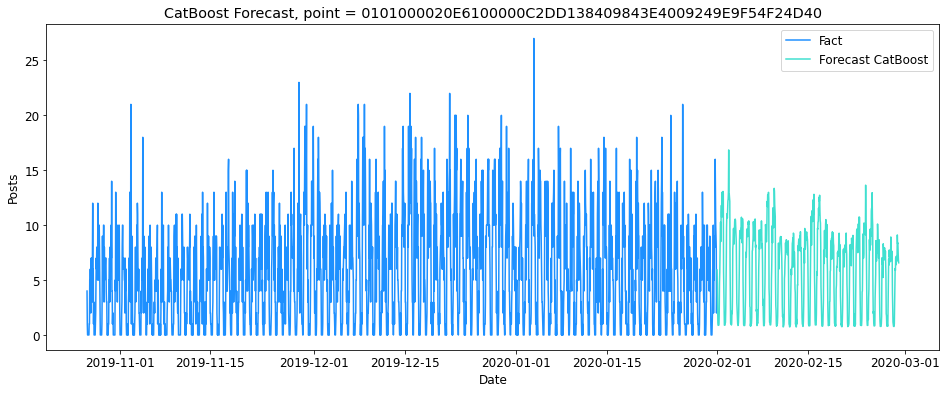

In [147]:
p = h_1.reset_index().query('point == "0101000020E6100000C2DD138409843E4009249E9F54F24D40" and year-month!="2020-02"').reset_index(drop=True)
f = t.reset_index().merge(calendar[['datetime','year', 'month', 'day', 'hour']], on = ['year', 'month', 'day', 'hour'], how = 'inner')\
.query('point == "0101000020E6100000C2DD138409843E4009249E9F54F24D40"').reset_index(drop=True).sort_values(by = 'datetime')
plt.figure(figsize=(16,6))
plt.plot(p['datetime'][-3000:-672],p['cnt_publications'][-3000:-672], label='Fact',color = 'dodgerblue')
plt.plot(f['datetime'],f['yhat_ctb'], label='Forecast CatBoost',color = 'turquoise')
plt.legend()
plt.title("CatBoost Forecast, point = 0101000020E6100000C2DD138409843E4009249E9F54F24D40") 
plt.ylabel('Posts',fontsize=12)
plt.xlabel('Date',fontsize=12)